# Multisensor fusion project
- Experiment data: June 2022. Maraging Steel 300
- Experiment number (single bead wall samples): 21-26
- Recorded data: position, veolocity, coaxial ccd features, acoustic feature, thermal features
- Defect generated: keyhole pores, cracks, defect-free

### Notebook 1: Acoustic data preprocessing

In [1]:
## Required python libraries
import pandas as pd
import numpy as np
import scipy as sp
import scipy.signal
import os
import math
import sys
from scipy.interpolate import griddata

# to make this notebook's output stable across runs
np.random.seed(42)

pd.plotting.register_matplotlib_converters()


import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
%matplotlib inline
import seaborn as sns
import librosa
import matplotlib.font_manager as font_manager

#---------------opencv------------------------
import cv2

In [2]:
import scaleogram as scg 
from glob import glob
import scipy
from scipy.signal import welch
import wave                    # library handles the parsing of WAV file headers
import pywt
import soundfile as sf
import glob
import re

In [3]:
# Pytorch libraryes and torchaudio - for GPU accelerated feature extraction
import torch
import torchaudio
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchsummary import summary

In [4]:
# ------------------- plotly visualizatoin----------------------------------
from PIL import Image
import plotly.io as pio
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
# from skimage import data

from glob import glob
import glob
import scipy
from scipy.signal import welch
import wave                    # library handles the parsing of WAV file headers
import pywt
import soundfile as sf
import matplotlib.font_manager as font_manager

In [5]:
## Audio signal processing libraries
import librosa
import librosa.display
import IPython.display as ipd
import plotly.express as px
import plotly.io as pio
# import nussl
import natsort

In [6]:
# Where to save the figures, and dataset locations
PROJECT_ROOT_DIR = "../"

Audio_ROOT = os.path.join("C:\\Users\\Asus\\OneDrive_Chen1470\\OneDrive - Nanyang Technological University\\Dataset\\LDED_audio_dataset")
             
Audio_PATH_original = os.path.join(Audio_ROOT, 'wave_file', "original")
Audio_PATH_equalized = os.path.join(Audio_ROOT, 'wave_file', "equalized")
Audio_PATH_bandpassed = os.path.join(Audio_ROOT, 'wave_file', "bandpassed")
Audio_PATH_denoised = os.path.join(Audio_ROOT, 'wave_file', "denoised",)


Multimodal_dataset_PATH = os.path.join("C:\\Users\\Asus\\OneDrive_Chen1470\\OneDrive - Nanyang Technological University\\Dataset\\Multimodal_AM_monitoring\\LDED_Acoustic_Visual_Dataset")
Audio_segmented_10Hz_PATH = os.path.join(Multimodal_dataset_PATH, 'Audio_signal_all_10Hz')
Audio_segmented_30Hz_PATH = os.path.join(Multimodal_dataset_PATH, 'Audio_signal_all_30Hz')
CCD_Image_10Hz_path = os.path.join(Multimodal_dataset_PATH, 'Coaxial_CCD_images_10Hz')
CCD_Image_30Hz_path = os.path.join(Multimodal_dataset_PATH, 'Coaxial_CCD_images_30Hz')


IMAGE_PATH = os.path.join(PROJECT_ROOT_DIR, "result_images", 'pre-processing')

os.makedirs(IMAGE_PATH, exist_ok=True)

## function for automatically save the diagram/graph into the folder 
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGE_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [7]:
def simple_visualization(sound, sr=44100, alpha = 1):
    fig, axs = plt.subplots(1, 1, tight_layout = True, figsize=(6, 3)) #constrained_layout=True,

    librosa.display.waveplot(sound, sr=sr, alpha=alpha, label = 'original signal')
    axs.set_xlabel('Time [sec]', fontsize = 14)
    axs.set_ylabel('Amplitute', fontsize = 14)

    # fig.suptitle("Time-domain visualisation", fontsize = 16)

## Load original signal

In [37]:
# load sounds
exp_21_raw, sr = librosa.load(os.path.join(Audio_PATH_original, "21.wav"), sr=None)
exp_22_raw, sr = librosa.load(os.path.join(Audio_PATH_original, "22.wav"), sr=None)
exp_23_raw, sr = librosa.load(os.path.join(Audio_PATH_original, "23.wav"), sr=None)
exp_24_raw, sr = librosa.load(os.path.join(Audio_PATH_original, "24.wav"), sr=None)
exp_25_raw, sr = librosa.load(os.path.join(Audio_PATH_original, "25.wav"), sr=None)
exp_26_raw, sr = librosa.load(os.path.join(Audio_PATH_original, "26.wav"), sr=None)
#----------------------------------------------------------------------------------
exp_21_equalized, sr  = librosa.load(os.path.join(Audio_PATH_equalized, "21_equalized.wav"), sr=None)
exp_22_equalized, sr = librosa.load(os.path.join(Audio_PATH_equalized, "22_equalized.wav"), sr=None)
exp_23_equalized, sr = librosa.load(os.path.join(Audio_PATH_equalized, "23_equalized.wav"), sr=None)
exp_24_equalized, sr = librosa.load(os.path.join(Audio_PATH_equalized, "24_equalized.wav"), sr=None)
exp_25_equalized, sr = librosa.load(os.path.join(Audio_PATH_equalized, "25_equalized.wav"), sr=None)
exp_26_equalized, sr = librosa.load(os.path.join(Audio_PATH_equalized, "26_equalized.wav"), sr=None)
#----------------------------------------------------------------------------------
exp_21_bandpassed, sr = librosa.load(os.path.join(Audio_PATH_bandpassed, "exp_21_bandpass.wav"), sr=None)
exp_22_bandpassed, sr = librosa.load(os.path.join(Audio_PATH_bandpassed, "exp_22_bandpass.wav"), sr=None)
exp_23_bandpassed, sr = librosa.load(os.path.join(Audio_PATH_bandpassed, "exp_23_bandpass.wav"), sr=None)
exp_24_bandpassed, sr = librosa.load(os.path.join(Audio_PATH_bandpassed, "exp_24_bandpass.wav"), sr=None)
exp_25_bandpassed, sr = librosa.load(os.path.join(Audio_PATH_bandpassed, "exp_25_bandpass.wav"), sr=None)
exp_26_bandpassed, sr = librosa.load(os.path.join(Audio_PATH_bandpassed, "exp_26_bandpass.wav"), sr=None)
#----------------------------------------------------------------------------------
exp_21_denoised, sr = librosa.load(os.path.join(Audio_PATH_denoised, "exp_21_denoised.wav"), sr=None)
exp_22_denoised, sr = librosa.load(os.path.join(Audio_PATH_denoised, "exp_22_denoised.wav"), sr=None)
exp_23_denoised, sr = librosa.load(os.path.join(Audio_PATH_denoised, "exp_23_denoised.wav"), sr=None)
exp_24_denoised, sr = librosa.load(os.path.join(Audio_PATH_denoised, "exp_24_denoised.wav"), sr=None)
exp_25_denoised, sr = librosa.load(os.path.join(Audio_PATH_denoised, "exp_25_denoised.wav"), sr=None)
exp_26_denoised, sr = librosa.load(os.path.join(Audio_PATH_denoised, "exp_26_denoised.wav"), sr=None)

In [38]:
# exp_21_raw = exp_21_raw[int(44100*17):int(44100*221.3)] 
# exp_21_equalized = exp_21_equalized[int(44100*17):int(44100*221.3)]
# exp_21_bandpassed = exp_21_bandpassed[int(44100*17):int(44100*221.3)]
# exp_21_denoised = exp_21_denoised[int(44100*17):int(44100*221.3)]


exp_22_raw = exp_22_raw[int(44100*18.15):int(44100*205.55)] #190.6 seconds, Previously (19-204.19). A total of 5614 melt pool images - 187.4 seconds
exp_22_equalized = exp_22_equalized[int(44100*18.15):int(44100*205.55)]
exp_22_bandpassed = exp_22_bandpassed[int(44100*18.15):int(44100*205.55)] #(180.3 - 205.7)
exp_22_denoised = exp_22_denoised[int(44100*18.15):int(44100*205.55)]


# exp_23_raw = exp_23_raw[int(44100*22.7):int(44100*475.2)] #475
# exp_23_equalized = exp_23_equalized[int(44100*22.7):int(44100*475.2)]
# exp_23_bandpassed = exp_23_bandpassed[int(44100*22.7):int(44100*475.2)]
# exp_23_denoised = exp_23_denoised[int(44100*22.7):int(44100*475.2)]


# exp_24_raw = exp_24_raw[int(44100*23):int(44100*865.3)] 
# exp_24_equalized = exp_24_equalized[int(44100*23):int(44100*865.3)]
# exp_24_bandpassed = exp_24_bandpassed[int(44100*23):int(44100*865.3)]
# exp_24_denoised = exp_24_denoised[int(44100*23):int(44100*865.3)]


# exp_25_raw = exp_25_raw[44100*19:]
# exp_25_equalized = exp_25_equalized[44100*19:]
# exp_25_bandpassed = exp_25_bandpassed[44100*19:]
# exp_25_denoised = exp_25_denoised[44100*19:]


# exp_26_raw = exp_26_raw[int(44100*10.8):int(44100*446.6)] #446
# exp_26_equalized = exp_26_equalized[int(44100*10.8):int(44100*446.6)]
# exp_26_bandpassed = exp_26_bandpassed[int(44100*10.8):int(44100*446.6)]
# exp_26_denoised = exp_26_denoised[int(44100*10.8):int(44100*446.6)]

## Random check

In [39]:
ipd.Audio(exp_22_denoised[int(44100*183.5):int(44100*186.4)], rate=sr)

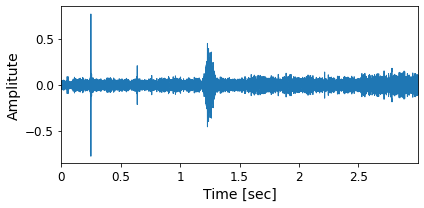

In [40]:
simple_visualization(exp_22_denoised[int(44100*9):int(44100*12)])
# # save_fig("25_simple_vis")

In [41]:
len(exp_22_denoised)/44100

187.40002267573695

## Segment the acoustic signal according to images

In [42]:
# Total length of sample 22 should be 187.4 seconds, images - 5615 ==> each segments 0.03338 seconds
# 187.4*44100 = 8,264,340; 8,264,340/5614 = 1,472

def segment_signal(signal, num_of_meltpool_pictures):
    num_samples_per_seg = int(len(signal)/num_of_meltpool_pictures)
    print (num_samples_per_seg)
    
    signal_seg = [] # list containing all small segments
    for i in range(num_of_meltpool_pictures):
        signal_seg.append(signal[(num_samples_per_seg*i):(num_samples_per_seg*(i+1))])
    print(len(signal_seg))
    return signal_seg
    
    
exp_22_raw_seg = segment_signal(exp_22_denoised, 5615) # 1602 for 10 Hz, 5614 for 30 Hz
exp_22_equalized_seg = segment_signal(exp_22_denoised, 5615)
exp_22_bandpassed_seg = segment_signal(exp_22_denoised, 5615)
exp_22_denoised_seg = segment_signal(exp_22_denoised, 5615)

1471
5615
1471
5615
1471
5615
1471
5615


### Inspections: selected examples

#### (1) crack location: image frame 306, 307, 308

In [55]:
test = []
list301 = list(exp_22_denoised_seg[301])
list302 = list(exp_22_denoised_seg[302])
list303 = list(exp_22_denoised_seg[303])
list304 = list(exp_22_denoised_seg[304])
list305 = list(exp_22_denoised_seg[305])
list306 = list(exp_22_denoised_seg[306])
list307 = list(exp_22_denoised_seg[307])
list308 = list(exp_22_denoised_seg[308])
list309 = list(exp_22_denoised_seg[309])
# test.extend(list301)
# test.extend(list302)
# test.extend(list303)
# test.extend(list304)
# test.extend(list305)
test.extend(list306)
test.extend(list307)
test.extend(list308)
test.extend(list309)

In [56]:
type(test)

list

In [57]:
test = np.asarray(test)

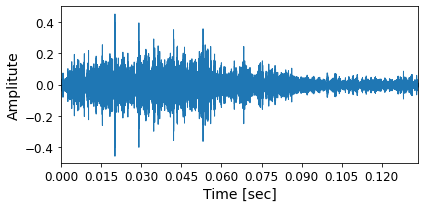

In [58]:
simple_visualization(test)

In [59]:
ipd.Audio(test, rate=sr)

#### (2) Laser-on: image frame 31 - 39; 34, 35, 36 are laser start

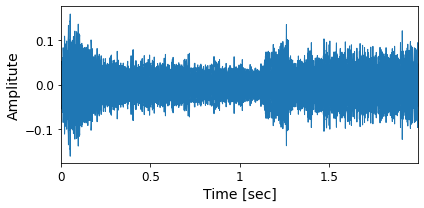

In [60]:
simple_visualization(exp_22_denoised[int(44100*0):int(44100*2)])

In [61]:
ipd.Audio(exp_22_denoised[int(44100*0):int(44100*2)], rate=sr)

In [65]:
test = []
list27 = list(exp_22_denoised_seg[27])
list28 = list(exp_22_denoised_seg[28])
list29 = list(exp_22_denoised_seg[29])
list30 = list(exp_22_denoised_seg[30])
list31 = list(exp_22_denoised_seg[31])
list32 = list(exp_22_denoised_seg[32])
list33 = list(exp_22_denoised_seg[33])
list34 = list(exp_22_denoised_seg[34])
list35 = list(exp_22_denoised_seg[35])
list36 = list(exp_22_denoised_seg[36])
list37 = list(exp_22_denoised_seg[37])
list38 = list(exp_22_denoised_seg[38])
# test.extend(list27)
# test.extend(list28)
# test.extend(list29)
# test.extend(list30)
# test.extend(list31)
# test.extend(list32)
test.extend(list33)
test.extend(list34)
test.extend(list35)
test.extend(list36)
test.extend(list37)
test.extend(list38)
test = np.asarray(test)

In [66]:
ipd.Audio(test, rate=sr)

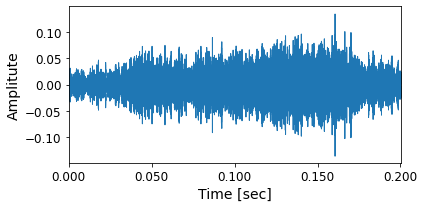

In [67]:
simple_visualization(test)

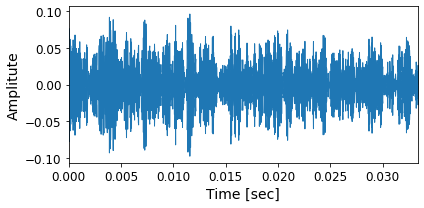

In [196]:
simple_visualization(exp_22_equalized_seg[168])

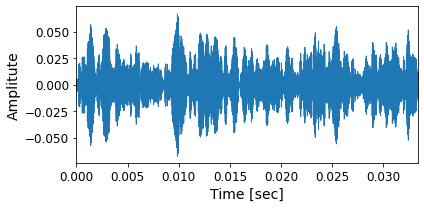

In [197]:
simple_visualization(exp_22_bandpassed_seg[10])

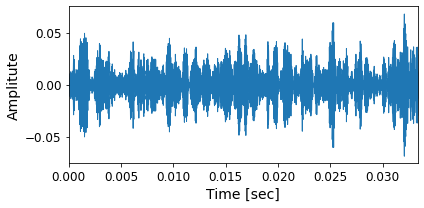

In [198]:
simple_visualization(exp_22_denoised_seg[12])

## Store the segmented signal into designated folder

In [68]:
len(exp_22_raw_seg)

5615

In [69]:
for i in range (0,len(exp_22_raw_seg)):
    sf.write(os.path.join(Audio_segmented_30Hz_PATH, 'raw', "Sample22_000"+ str(i) + ".wav"), exp_22_raw_seg[i], samplerate=44100)
    sf.write(os.path.join(Audio_segmented_30Hz_PATH, 'equalized', "Sample22_000"+ str(i) + ".wav"), exp_22_equalized_seg[i], samplerate=44100)
    sf.write(os.path.join(Audio_segmented_30Hz_PATH, 'bandpassed', "Sample22_000"+ str(i) + ".wav"), exp_22_bandpassed_seg[i], samplerate=44100)
    sf.write(os.path.join(Audio_segmented_30Hz_PATH, 'denoised', "Sample22_000"+ str(i) + ".wav"), exp_22_denoised_seg[i], samplerate=44100)

## Calculate mean and std for images

In [17]:
import numpy as np
import torch
from PIL import Image


image_paths = [] # list of image paths
for filename in os.listdir(CCD_Image_10Hz_path):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        image_paths.append(os.path.join(CCD_Image_10Hz_path, filename))
        
        
# calculate mean and std of the dataset
image_data = []
for path in image_paths:
    img = Image.open(path).convert('L')
    img = img.resize((32,32)) # resizing
    img = np.array(img)
    image_data.append(img)
image_data = np.concatenate(image_data)

mean = np.mean(image_data)
std = np.std(image_data)
print(mean, std)

136.20371045013258 61.9731240029325


In [20]:
img = Image.open(image_paths[1500]).convert('L')
img = img.resize((32,32)) # resizing
img.show()